In [118]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from sklearn import metrics

 
import re
import sweetviz as sv
import datetime
final_date = '2021-01-18'

### normalize 釋義:是否對數據進行標準化處理
設置:bool型,可選,默認False,建議將標準化的工作放在訓練模型之前,通過設置sklearn.preprocessing.StandardScaler來實現，而在此處設置為false 當fit_intercept設置為false的時候，這個參數會被自動忽略。如果為True,回歸器會標準化輸入參數：減去平均值，並且除以相應的二範數


### copy_X 釋義:是否對X複製
設置:bool型、可選、默認True,如為false，則即經過中心化，標準化後，把新數據覆蓋到原數據上

### n_jobs釋義:計算時設置的任務個數,
這一參數的對於目標個數>1（n_targets>1）且足夠大規模的問題有加速作用
設置:int or None, optional, 默認None,如果選擇-1則代表使用所有的CPU。


In [119]:
def trainLR(df):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    import joblib

    X,Y = preHandleDat(df,True)
    
    #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.2,random_state=587)
    # print the data
    model = LinearRegression(fit_intercept=True, normalize=True, copy_X=True) #fit_intercept=False
   
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    #print(y_predict)
    
    print("r2:", model.score(X_test, y_test)) # 拟合优度R2的输出方法
    print("MAE:", metrics.mean_absolute_error(y_test, y_predict))# 用Scikit_learn计算MAE
    print("MSE:", metrics.mean_squared_error(y_test, y_predict))# 用Scikit_learn计算MSE
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))# 用Scikit_learn计算RMSE
    print("intercept_ :",model.intercept_)
    # print("coef_", model.coef_)

    joblib.dump(model, 'LR_model')

    # loo = cross_validation.LeaveOneOut(len(y_train))
    # scores = cross_validation.cross_val_score(model, X_train, y_train, scoring='mean_squared_error', cv=loo,)
    # # This will print the mean of the list of errors that were output and 
    # # provide your metric for evaluation
    # print(scores.mean())


    return y_predict

In [120]:
def testLR(df):
    from sklearn.linear_model import LinearRegression
    import joblib
    X_test,y_test = preHandleDat(df,False)
    # print(X_test)
    #print(X_test,y_test)
    loaded_model = joblib.load('LR_model')
    y_predict = loaded_model.predict(X_test)
    df['predict'] = y_predict
    
    loaded_model.score(X_test, y_test)
    print("test r2:", loaded_model.score(X_test, y_test))
    # y_test real 与 y_predict的可视化
    # 设置图片尺寸
    plt.figure(figsize=(10, 6))
    t = np.arange(len(X_test))# 创建t变量
    plt.plot(t, y_test, 'r', linewidth=1, marker='.', label='real') # 绘制y_test曲线
    plt.plot(t, y_predict, 'g', linewidth=1, marker='.', label='predict') # 绘制predict曲线
    plt.legend()# 设置图例
    plt.savefig('./Result/test.png')
    return df


In [121]:
def preHandleDat(df,isTrain=True):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化

    
    #=================
    #刪除不必要的欄位
    #=================
    drop_cols=['MFG_DATE','ARRIVAL_WIP_QTY','NO_HOLD_QTY']
    df = df.drop(drop_cols, axis=1)
    #df_train['Finish']=np.where(df_train['TOOLG_ID_NEXT'].isnull(), 1, 0).astype(str)
    #df_train['WEEKDAY']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()
    # df['MFG_DATE']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d')
    #'IS_HOLIDAY'
     
    # df = df.drop('WIP_QTY', axis=1)
    # df = df.sort_values('NO_HOLD_QTY')
    # print("DATA Start====")
    # print(df.info())  
    #========================
    # 缺漏值填空
    #========================
    # df = df.fillna(df.median())
    df = df.fillna(method='bfill')
    # df = df.fillna(df.mean())        
    #==================================================
    #1.特徵縮放
    #==================================================
    
    #特徵縮放欄位 List(排除Target TRCT)==================
    # num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE']

    num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE'] #'ARRIVAL_WIP_QTY',
    df_train_scal = df
    #rescaling 特徵縮放 StandardScaler-------------------------------------
    # std_scaler = StandardScaler()
    # std_scaler.fit(df_train[num_cols])

    # df_train_scal[num_cols]= std_scaler.transform(df_train_scal[num_cols])
 

    #rescaling 特徵縮放 MinMaxScaler-------------------------------------
    minMax_scaler = MinMaxScaler()
    minMax_scaler.fit(df[num_cols])
    df_train_scal[num_cols]= minMax_scaler.transform(df_train_scal[num_cols])

    #rescaling 特徵縮放 RobustScaler-------------------------------------
    # robust_scaler = RobustScaler()
    # robust_scaler.fit(df_train[num_cols])
    # df_train_scal[num_cols] = robust_scaler.transform(df_train_scal[num_cols])
    
    #==================================================
    #2.one hot encoder
    #==================================================

    target_cols=['MOVE_QTY']
    cat_cols = ['TOOLG_ID']
    global df2_train_eh_before
    df_train_eh =pd.get_dummies(df_train_scal.drop(target_cols, axis=1),columns=cat_cols)
    if isTrain:
        df2_train_eh_before = df_train_eh
    else:
        df_train_eh = df_train_eh.reindex(columns = df2_train_eh_before.columns, fill_value=0)


    #print(df_train_scal.drop(target_cols, axis=1).describe())
    # print("one hot encoder====")
    # print(df_train_eh.info())


    # df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
    #df_test_eh = df_test_eh.reindex(columns = df_test_eh.columns, fill_value=0)
   
    #np.asarray(x).astype('float32')        
           
    X_dropped = np.asarray(df_train_eh)

    Y_dropped = np.asarray(df[target_cols]) #'MOVE_QTY'
    return X_dropped,Y_dropped
    

In [122]:
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

In [123]:
def EDA(df_train,targetfeat='MOVE_QTY'):
    
    pairwise_analysis='off' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
    report_train = sv.analyze([df_train, 'train'],
                                    target_feat= targetfeat
    )
    report_train.show_html(filepath='./sweetvizHTML/train_report.html' ) # 儲存為html的格式

    # compare_subsets_report = sv.compare_intra(df_train,
    #                                         df_train['Finish']==1, # 給條件區分
    #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
    #                                         target_feat='NO_HOLD_QTY',
    #                                         )

    # compare_subsets_report.show_html(filepath='./sweetvizHTML/HW2_Compare_report.html')

In [124]:
df_train_orign=readDataFromFile('./data/TRCT_TrainingData_20210131.csv')
#df_train_orign['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 
df_train_orign['MFG_DATE'] = df_train_orign['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

df_train = df_train_orign
# df_train.info()
# 1. 查看缺失情况
# print(df_train.isnull().sum())
# print(df_train.describe())# 128683

#df2_test = df2_test.dropna()# 刪除null值

# 'MFG_DATE','TOOLG_ID','IS_HOLIDAY','M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','MOVE_QTY','ARRIVAL_WIP_QTY','RUN_WIP_RATIO','CLOSE_WIP_QTY','MANAGEMENT_WIP_QTY','C_TC','C_CLOSE_WIP','C_TOOLG_LOADING','C_TOOL_LOADING','DISPATCHING','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','[BACKUP]','REWORK_RATE','QUE_LOT_RATE','SAMPLING_RATE','NUM_RECIPE','CHANGE_RECIPE','BATCH_SIZE'
# num_cols=['WIP_QTY','NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
# missData(df_train)

#刪除columns 值是空的()
df_train = df_train.dropna(axis=1, how='all')
 
# #刪除rows ,target值是空的()
df_train = df_train[df_train['MOVE_QTY'].notna()]
df_train = df_train[df_train['NO_HOLD_QTY'].notna()]
# df_train.info()
print(df_train.isnull().sum())


MFG_DATE            0
TOOLG_ID            0
IS_HOLIDAY          0
M_NUM               0
UP_TIME             0
C_UP_TIME           1
LOT_SIZE            0
C_LOT_SIZE          1
EQP_UTIL            0
C_EQP_UTIL          1
U                  90
PROCESS_TIME        0
WIP_QTY             0
NO_HOLD_QTY         0
MOVE_QTY            0
ARRIVAL_WIP_QTY     0
RUN_WIP_RATIO       0
C_TC                1
HOLD_RATE           0
ENG_LOT_RATE        0
HOT_LOT_RATE        0
QUE_LOT_RATE        0
dtype: int64


## 資料分析 Tool

In [125]:

#資料分析 Tool
#EDA(df_train,'TRCT')


In [126]:
# 檢查資料處理  value  是不是有 無限大
# print(np.all(np.isfinite(x)))
# print(np.all(np.isfinite(y)))


# 模型 訓練

In [127]:

df_train1 = df_train[df_train['MFG_DATE'] <  pd.to_datetime(final_date)]
df_train1['MFG_DATE'].max()

Timestamp('2021-01-17 00:00:00')

In [128]:
# trainLR(df_train)
trainLR(df_train1)


r2: 0.9936584013264741
MAE: 440.0677364774311
MSE: 1664610.4904558063
RMSE: 1290.1978493455204
intercept_ : [3.54026235e+13]


array([[ 1131.6875   ],
       [39637.3046875],
       [  522.8828125],
       ...,
       [ 2997.59375  ],
       [  306.421875 ],
       [  648.9375   ]])

# 推估當天 28天 df_sum28

In [129]:
test = df_train1 # 20以前的資料集
# test['MFG_DATE'] = pd.to_datetime(test['MFG_DATE'],format='%Y%m%d') 

df = test.groupby('TOOLG_ID').apply(lambda x: x.set_index('MFG_DATE').resample('1D').first())
# df = test.groupby('User').apply(lambda x: x.set_index('Date').resample('1D').first())

In [130]:
num_cols=['M_NUM','UP_TIME','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','EQP_UTIL','C_EQP_UTIL','U','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY', 'ARRIVAL_WIP_QTY','RUN_WIP_RATIO','C_TC','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
# num_cols=['M_NUM']
# df1[num_cols] = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean())
# df1 = df.groupby(level=0)['Value']
#         .apply(lambda x: x.shift().rolling(min_periods=1,window=2).mean())
#         .reset_index(name='Value_Average_Past_2_days')

df_sum28 = df.groupby(level=0)[num_cols].apply(lambda x: x.shift().rolling(min_periods=1,window=28).mean()).reset_index()


In [131]:
#df_train1['MFG_DATE'].max()
df_sum28['MFG_DATE'].max()

Timestamp('2021-01-17 00:00:00')

## 抓最後一天的數據  來預測當天的值 df_test_today


In [132]:
df_test_today=df_sum28.loc[df_sum28['MFG_DATE']==df_sum28['MFG_DATE'].max()]
# df_val_today=df_train.loc[df_train['MFG_DATE']=='2021-2-01']

In [133]:
 
df_test_today['MFG_DATE'] = df_sum28['MFG_DATE'].max()+ datetime.timedelta(days=1)
weekno = df_test_today['MFG_DATE'].max().weekday()

if weekno < 5:
    df_test_today['IS_HOLIDAY'] = 1.0527
else:  # 5 Sat, 6 Sun
    df_test_today['IS_HOLIDAY'] =1

##取得當天的生產資訊
#### C_LOT_SIZE
#### LOT_SIZE
#### PROCESS_TIME
#### WIP_QTY
#### NO_HOLD_QTY
#### ARRIVAL_WIP_QTY
#### HOLD_RATE
#### ENG_LOT_RATE
#### HOT_LOT_RATE
#### QUE_LOT_RATE

In [134]:

# df_test_today = df_test_today.set_index(['MFG_DATE','TOOLG_ID'])
real_data_cols_withkeys =['MFG_DATE','TOOLG_ID','C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
real_data_cols =['C_LOT_SIZE','LOT_SIZE','PROCESS_TIME','WIP_QTY','NO_HOLD_QTY','ARRIVAL_WIP_QTY','HOLD_RATE','ENG_LOT_RATE','HOT_LOT_RATE','QUE_LOT_RATE','MOVE_QTY']
df_map_today = df_train[real_data_cols_withkeys] 
df_map_today=df_map_today.loc[df_map_today['MFG_DATE']==df_test_today['MFG_DATE'].max()]

for index, row in df_test_today.iterrows():
    r = df_map_today[real_data_cols].loc[(df_map_today['MFG_DATE']==row['MFG_DATE'])  & (df_map_today['TOOLG_ID']==row['TOOLG_ID'])]
    if(r.any(axis=None)):
        for col in real_data_cols:
            df_test_today.loc[index,col]  =r[col].values
    else:
         df_test_today.drop(index, inplace=True)
    
# df_test_today['MOVE_QTY']=1 #先帶入預設值

In [135]:
print(df_train1.shape)
df_test_today.to_csv('./data/MyToday20200120_CT.csv')

(93266, 22)


test r2: 0.9949671715535122


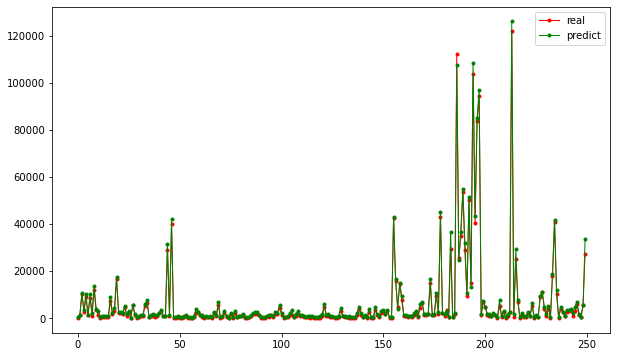

In [136]:
testLR(df_test_today).to_csv('./data/MyToday20200120_result_CT.csv')
# testLR( df_train[df_train['MFG_DATE'] ==  pd.to_datetime(final_date)  + datetime.timedelta(days=1)])